# Elliptical Slice Sampling
The purpose of this notebook is to check if the `elliptic.py` file implementing Elliptical Slice Sampling works as expected, whilst demonstrating how it can be used to sample from the latent variable posterior $p(\mathbf{f} | \mathbf{y}, \boldsymbol{\theta})$.

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from gproc.elliptic_cpp import ess_samples_probit
from gproc.generative import sample_at_x
from gproc.kernels import squared_exponential
from gproc.kernels import rational_quadratic
from gproc.kernels import periodic

## Data Generation

In [2]:
N = 500 # Data size
D = 1 # Data dimension

x = np.random.uniform(-1, 1, N * D).reshape(-1, D) # Reshape to N x D matrix
#y, prob_y, f = sample_at_x(x, kernel_fcn=periodic, kernel_params = {'lengthscale': 1, 'variance': 1.4, 'period':2})
y, prob_y, f = sample_at_x(x, kernel_fcn=squared_exponential, kernel_params = {'lengthscale': 0.1, 'variance': 1.4})
y=y.astype("float64")

## Generate Latent Posterior Samples

In [3]:
model_lengthscale=0.1
model_variance=1.4
K = squared_exponential(x, x, lengthscale=model_lengthscale, variance=model_variance)
#K = rational_quadratic(x, x, lengthscale=0.1, variance=1.4, weighting=1)
#K = periodic(x, x, lengthscale=1, variance=1.4, period=2)
K_chol = np.linalg.cholesky(K + 0.0001*np.eye(K.shape[0]))
samples = ess_samples_probit(K_chol, y, 2500, 500)

100%|███████████████████████████████████████████████████████████████████████████████| 2999/2999 [01:28<00:00, 33.98it/s]


## Mean of Samples Against True Function and Laplace

### ESS Samples Mean

In [4]:
ess_mean = np.mean(samples, axis=0)

In [5]:
samples

array([[-0.52104456, -1.00540359,  0.86511382, ..., -1.6634863 ,
        -0.58009552,  1.15105891],
       [-0.57681439, -1.00591186,  0.8839321 , ..., -1.62501655,
        -0.62293133,  1.11626644],
       [-0.52518805, -0.96737149,  0.83211405, ..., -1.60428827,
        -0.56908516,  1.071933  ],
       ...,
       [-0.48589022, -1.31733302,  1.01123705, ..., -2.36924488,
        -0.54660081,  0.95747577],
       [-0.49036968, -1.40450377,  0.94639527, ..., -2.44722705,
        -0.60523227,  0.8630945 ],
       [-0.72347155, -1.53545693,  0.84870562, ..., -2.46990994,
        -0.75874919,  1.11667445]])

### Laplace Approximation

In [6]:
from gproc.laplace import laplace_approximation_probit, chol_inverse

laplace_mean, df_ll, laplace_cov, objective_history, converged = laplace_approximation_probit(y, chol_inverse(K))

In [7]:
laplace_samples = np.random.multivariate_normal(laplace_mean, laplace_cov, 2500)

## Plot Means

In [8]:
ess_mean.shape

(500,)

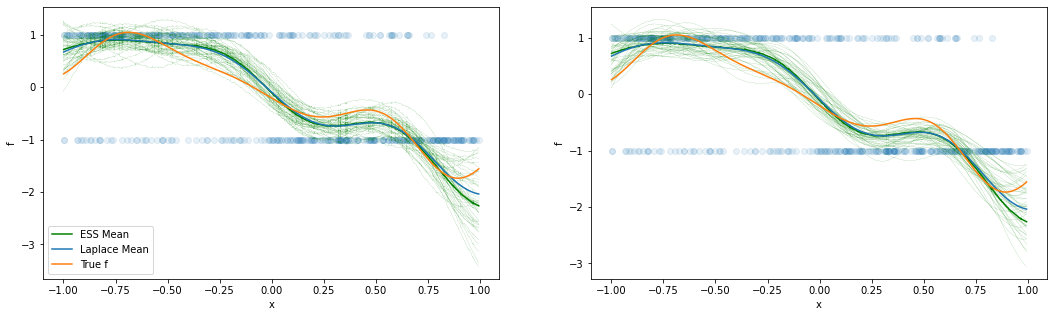

In [9]:
sort_ix = np.argsort(x.reshape(-1))

fig, axarr = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={'width_ratios': [1,1]})

axarr[0].scatter(x, y, alpha=0.1)
axarr[0].set_xlabel('x')
axarr[0].set_ylabel('f')

for i in range(0, samples.shape[0], 50):
    axarr[0].plot(x[sort_ix], samples[i, sort_ix], c = 'g', linewidth = 0.1)

axarr[0].plot(x[sort_ix], ess_mean[sort_ix], c='g', label='ESS Mean')
axarr[0].plot(x[sort_ix], laplace_mean[sort_ix], label='Laplace Mean')
axarr[0].plot(x[sort_ix], f[sort_ix], label='True f')

axarr[0].legend()

axarr[1].scatter(x, y, alpha=0.1)
axarr[1].set_xlabel('x')
axarr[1].set_ylabel('f')

for i in range(0, laplace_samples.shape[0], 50):
    axarr[1].plot(x[sort_ix], laplace_samples[i, sort_ix], c = 'g', linewidth = 0.1)

axarr[1].plot(x[sort_ix], ess_mean[sort_ix], c='g', label='ESS Mean')
axarr[1].plot(x[sort_ix], laplace_mean[sort_ix], label='Laplace Mean')
axarr[1].plot(x[sort_ix], f[sort_ix], label='True f')
axarr[0].legend()

(array([  1.,   1.,   1.,   5.,   3.,   6.,  11.,  15.,   7.,  10.,  22.,
         27.,  39.,  54.,  52.,  65.,  70.,  69.,  96., 105., 129., 120.,
        138., 157., 108., 121., 122., 120., 116., 111., 131.,  82.,  82.,
         64.,  63.,  43.,  32.,  32.,  31.,   9.,   9.,   9.,   8.,   1.,
          0.,   1.,   1.,   0.,   0.,   1.]),
 array([-1.24347501, -1.22268992, -1.20190483, -1.18111974, -1.16033465,
        -1.13954956, -1.11876448, -1.09797939, -1.0771943 , -1.05640921,
        -1.03562412, -1.01483903, -0.99405394, -0.97326886, -0.95248377,
        -0.93169868, -0.91091359, -0.8901285 , -0.86934341, -0.84855832,
        -0.82777323, -0.80698815, -0.78620306, -0.76541797, -0.74463288,
        -0.72384779, -0.7030627 , -0.68227761, -0.66149252, -0.64070744,
        -0.61992235, -0.59913726, -0.57835217, -0.55756708, -0.53678199,
        -0.5159969 , -0.49521181, -0.47442673, -0.45364164, -0.43285655,
        -0.41207146, -0.39128637, -0.37050128, -0.34971619, -0.32893111,
 

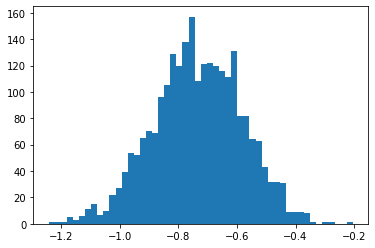

In [10]:
plt.hist(samples[:,0], bins=50)